<a href="https://colab.research.google.com/github/ejnunn/GAN_Research/blob/main/notebooks/AFID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !rm -r GAN_Research
!git clone --quiet https://github.com/ejnunn/GAN_Research.git
!pip install torchextractor

In [3]:
import torch
import torchvision
import torchextractor as tx
import multiprocessing
import numpy as np
import cv2
from scipy import linalg
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import tqdm

# FID Functions

In [4]:
def get_activations(images, batch_size):
    """
    Calculates activations for last pool layer for all iamges
    --
        Images: torch.array shape: (N, 3, 299, 299), dtype: torch.float32
        batch size: batch size used for inception network
    --
    Returns: np array shape: (N, 2048), dtype: np.float32
    """
    assert images.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                              ", but got {}".format(images.shape)

    num_images = images.shape[0]
    original_model = torchvision.models.inception_v3(pretrained=True)
    fid_layers = ['maxpool1', 'maxpool2', 'avgpool']

    assert all(x in tx.list_module_names(original_model) for x in fid_layers), "Inception_v3 model does not contain necessary layers for FID calculations"
    
    inception_network = tx.Extractor(original_model, fid_layers)
    inception_network = to_cuda(inception_network)
    inception_network.eval()
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)

        ims = images[start_idx:end_idx]
        ims = to_cuda(ims)
        model_output, features = inception_network(ims)
        act1, act2, act3 = features.values()

        act1 = act1.detach().cpu().numpy().flatten()
        act1 = np.expand_dims(act1, axis=0)
        act2 = act2.detach().cpu().numpy().flatten()
        act2 = np.expand_dims(act2, axis=0)
        act3 = act3.detach().cpu().numpy().squeeze()
        act3 = np.expand_dims(act3, axis=0)
        
        assert act1.shape == (ims.shape[0], 341056), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 341056), act1.shape)
        assert act2.shape == (ims.shape[0], 235200), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 235200), act2.shape)
        assert act3.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), act3.shape)
        
    return act1, act2, act3

In [5]:
def calculate_activation_statistics(images, batch_size):
    """Calculates the statistics used by FID
    Args:
        images: torch.tensor, shape: (N, 3, H, W), dtype: torch.float32 in range 0 - 1
        batch_size: batch size to use to calculate inception scores
    Returns:
        mu:     mean over all activations from the last pool layer of the inception model
        sigma:  covariance matrix over all activations from the last pool layer 
                of the inception model.
    """
    act1, act2, act3 = get_activations(images, batch_size)
    
    mu1 = np.mean(act1, axis=0)
    mu2 = np.mean(act2, axis=0)
    mu3 = np.mean(act3, axis=0)

    sigma1 = np.cov(act1, rowvar=False)
    sigma2 = np.cov(act2, rowvar=False)
    sigma3 = np.cov(act3, rowvar=False)
    return mu1, mu2, mu3, sigma1, sigma2, sigma3

In [6]:
# Modified from: https://github.com/bioinf-jku/TTUR/blob/master/fid.py
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [13]:
def calculate_afid(images1, images2, use_multiprocessing, batch_size):
    """ Calculate FID between images1 and images2
    Args:
        images1: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        images2: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
        batch size: batch size used for inception network
    Returns:
        FID (scalar)
    """
    images1 = preprocess_images(images1, use_multiprocessing)
    images2 = preprocess_images(images2, use_multiprocessing)
    mu11, mu12, mu13, sigma11, sigma12, sigma13 = calculate_activation_statistics(images1, batch_size)
    mu21, mu22, mu23, sigma21, sigma22, sigma23 = calculate_activation_statistics(images2, batch_size)
    fid1 = calculate_frechet_distance(mu11, sigma11, mu21, sigma21) / 341056 * 2048 # normalize with 2048-feature fid score
    fid2 = calculate_frechet_distance(mu12, sigma12, mu22, sigma22) / 235200 * 2048 # normalize with 2048-feature fid score
    fid3 = calculate_frechet_distance(mu13, sigma13, mu23, sigma23)

    # maxpool1 torch.Size([341056])
    # maxpool2 torch.Size([235200])
    # avgpool torch.Size([2048])

    return fid1, fid2, fid3

In [8]:
def preprocess_image(im):
    """Resizes and shifts the dynamic range of image to 0-1
    Args:
        im: np.array, shape: (H, W, 3), dtype: float32 between 0-1 or np.uint8
    Return:
        im: torch.tensor, shape: (3, 299, 299), dtype: torch.float32 between 0-1
    """
    assert im.shape[2] == 3
    assert len(im.shape) == 3
    if im.dtype == np.uint8:
        im = im.astype(np.float32) / 255
    if im.dtype == np.float64:
        im = im.astype(np.float32) / 255
    im = cv2.resize(im, (299, 299))
    im = np.rollaxis(im, axis=2)
    im = torch.from_numpy(im)
    assert im.max() <= 1.0
    assert im.min() >= 0.0
    assert im.dtype == torch.float32
    assert im.shape == (3, 299, 299)

    return im

In [9]:
def preprocess_images(images, use_multiprocessing):
    """Resizes and shifts the dynamic range of image to 0-1
    Args:
        images: np.array, shape: (N, H, W, 3), dtype: float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
    Return:
        final_images: torch.tensor, shape: (N, 3, 299, 299), dtype: torch.float32 between 0-1
    """
    if use_multiprocessing:
        with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
            jobs = []
            for im in images:
                job = pool.apply_async(preprocess_image, (im,))
                jobs.append(job)
            final_images = torch.zeros(images.shape[0], 3, 299, 299)
            for idx, job in enumerate(jobs):
                im = job.get()
                final_images[idx] = im#job.get()
    else:
        final_images = torch.stack([preprocess_image(im) for im in images], dim=0)
    assert final_images.shape == (images.shape[0], 3, 299, 299)
    assert final_images.max() <= 1.0
    assert final_images.min() >= 0.0
    assert final_images.dtype == torch.float32
    return final_images

In [10]:
def to_cuda(elements):
    """
    Transfers elements to cuda if GPU is available
    Args:
        elements: torch.tensor or torch.nn.module
        --
    Returns:
        elements: same as input on GPU memory, if available
    """
    if torch.cuda.is_available():
        return elements.cuda()
    return elements

In [11]:
def load_images(path, verbose=False):
    """ Loads all .png or .jpg images from a given path
    Warnings: Expects all images to be of same dtype and shape.
    Args:
        path: relative path to directory
    Returns:
        final_images: np.array of image dtype and shape.
    """
    image_paths = []
    image_extensions = ["png", "jpg"]
    for ext in image_extensions:
        if verbose:
            print("Looking for images in", os.path.join(path, "*.{}".format(ext)))
        for impath in glob.glob(os.path.join(path, "*.{}".format(ext))):
            image_paths.append(impath)
    first_image = cv2.imread(image_paths[0])
    W, H = first_image.shape[:2]
    image_paths.sort()
    image_paths = image_paths
    final_images = np.zeros((len(image_paths), W, H, 3), dtype=first_image.dtype)
    for idx, impath in enumerate(image_paths):
        im = cv2.imread(impath)
        im = im[:, :, ::-1] # Convert from BGR to RGB
        assert im.dtype == final_images.dtype
        final_images[idx] = im
    return final_images

# Calc FID

In [12]:
original_model = torchvision.models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


## Example 1 - Random Tensors

In [ ]:
# Example FID calculations using random tensors
# N x H x W x C
images1 = np.random.rand(128,299,299,3)
images2 = np.random.rand(128,299,299,3)

fid_value1, fid_value2, fid_value3 = calculate_afid(images1, images2, use_multiprocessing=False, batch_size=1)
print('fid_value1 =', fid_value1)
print('fid_value2 =', fid_value2)
print('fid_value3 =', fid_value3)

fid_value1 = 0.003159420108637774
fid_value2 = 0.005386332298023744
fid_value3 = 0.0006770001237672435


## Example 2 - Increasing Distortion

### Load Data

In [17]:
# Load original directories from Drive
!cp -r /content/drive/MyDrive/GAN_Research/Datasets/WarpedFace/ .

# Separate images into folders for individual FIDs between edited images
# Blur
!mkdir WarpedFace/blur/0/
!mkdir WarpedFace/blur/1/
!mkdir WarpedFace/blur/2/
!mkdir WarpedFace/blur/3/
!mv WarpedFace/blur/blur0.jpg WarpedFace/blur/0/
!mv WarpedFace/blur/blur1.jpg WarpedFace/blur/1/
!mv WarpedFace/blur/blur2.jpg WarpedFace/blur/2/
!mv WarpedFace/blur/blur3.jpg WarpedFace/blur/3/

# Gaussian Noise
!mkdir WarpedFace/noise/0/
!mkdir WarpedFace/noise/1/
!mkdir WarpedFace/noise/2/
!mkdir WarpedFace/noise/3/
!mv WarpedFace/noise/gaussian0.jpg WarpedFace/noise/0/
!mv WarpedFace/noise/gaussian1.jpg WarpedFace/noise/1/
!mv WarpedFace/noise/gaussian2.jpg WarpedFace/noise/2/
!mv WarpedFace/noise/gaussian3.jpg WarpedFace/noise/3/

# Salt & Pepper
!mkdir WarpedFace/sp/0/
!mkdir WarpedFace/sp/1/
!mkdir WarpedFace/sp/2/
!mkdir WarpedFace/sp/3/
!mv WarpedFace/sp/sp0.jpg WarpedFace/sp/0/
!mv WarpedFace/sp/sp1.jpg WarpedFace/sp/1/
!mv WarpedFace/sp/sp2.jpg WarpedFace/sp/2/
!mv WarpedFace/sp/sp3.jpg WarpedFace/sp/3/

# Warp
!mkdir WarpedFace/warp/0/
!mkdir WarpedFace/warp/1/
!mkdir WarpedFace/warp/2/
!mkdir WarpedFace/warp/3/
!mv WarpedFace/warp/warp0.jpg WarpedFace/warp/0/
!mv WarpedFace/warp/warp1.jpg WarpedFace/warp/1/
!mv WarpedFace/warp/warp2.jpg WarpedFace/warp/2/
!mv WarpedFace/warp/warp3.jpg WarpedFace/warp/3/

### Helper functions

In [64]:
### Plot Results

def afid_plot_2x2(distortion_fids: np.ndarray, distortion_titles=['noise', 'warp', 'sp', 'blur']):

  '''
  Creates a plot containing 4 subplots, each showing the correlation of AFID to
  the level of distortion applied to the original image.
  Parameters:
      <np.array> distortion_fids - AFID scores from 4 images, each with 4 levels of distortion

  Returns:
      fig: Figure
      axs: np.ndarray
  '''
  fig, axs = plt.subplots(2, 2, figsize=(10,10), sharey=True)

  fig.suptitle('FID scores based on image distortion level')

  afid_subplot(axs[0,0], distortion_fids[0], title=distortion_titles[0], show_legend=True)
  fig.legend()
  afid_subplot(axs[0,1], distortion_fids[1], title=distortion_titles[1], show_legend=False)
  afid_subplot(axs[1,0], distortion_fids[2], title=distortion_titles[2], show_legend=False)
  afid_subplot(axs[1,1], distortion_fids[3], title=distortion_titles[3], show_legend=False)


  # Hide x labels and tick labels for top plots and y ticks for right plots.


  return fig, axs



def afid_subplot(ax, fids: np.ndarray, title: str, show_legend: bool=False):
  '''
  Creates a single subplot within the 2x2 plot of distortion AFID results.

  Returns:
  '''

  x = [0,1,2,3]

  for i in range(fids.shape[1]):
    # Plot AFID_3 in BOLD for emphasis
    if i == 2:
      ax.plot(x, fids[:,i], label='AFID{}'.format(i+1), linewidth=3.0)
    else:
      ax.plot(x, fids[:,i], label='AFID{}'.format(i+1), linewidth=1.0)

  ax.set_title(title)
  ax.set_xlabel(xlabel='Edit Strength')
  ax.set_ylabel(ylabel='FID')

In [65]:
def distortion_fids(dist_type):
  '''
  Calculates the 3 FID scores between the originial image and a distorted version
  Parameters:
      dist_type: str, type of distortion (used for file paths)
  Returns:
      fids: list[list[float]], Matrix of fid scores shape: (4,3)
  '''
  fids = []
  for i in range(4):
    path1 = '/content/WarpedFace/{}/0/'.format(dist_type)
    path2 = '/content/WarpedFace/{}/{}/'.format(dist_type, str(i))
    images1 = load_images(path1)
    images2 = load_images(path2)
    fid1, fid2, fid3 = calculate_afid(images1, images2, use_multiprocessing=False, batch_size=1)
    fids.append([fid1, fid2, fid3])
  return np.array(fids)

In [113]:
def image_grid_1x4(images):
  fig, axs = plt.subplots(1,4)

  for i in range(len(images)):
    img = Image.open(images[i])
    axs[i].imshow(img)

  axs[0].get_xaxis().set_visible(False)

  return fig, axs

### Run Example

/content/WarpedFace/warp/0/warp0.jpg


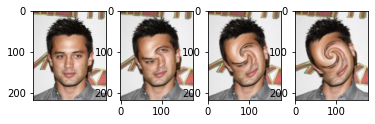

In [112]:
basepath = '/content/WarpedFace/warp'
dist_lvls = sorted(os.listdir(basepath))

warp_images = ['{}/{}/{}{}.jpg'.format(basepath, lvl, 'warp', lvl) for lvl in dist_lvls]

fig, axs = image_grid(warp_images)

In [56]:
# Calculate AFIDS for all distortion types

noise_fids = distortion_fids('noise')
blur_fids = distortion_fids('blur')
warp_fids = distortion_fids('warp')
sp_fids = distortion_fids('sp')

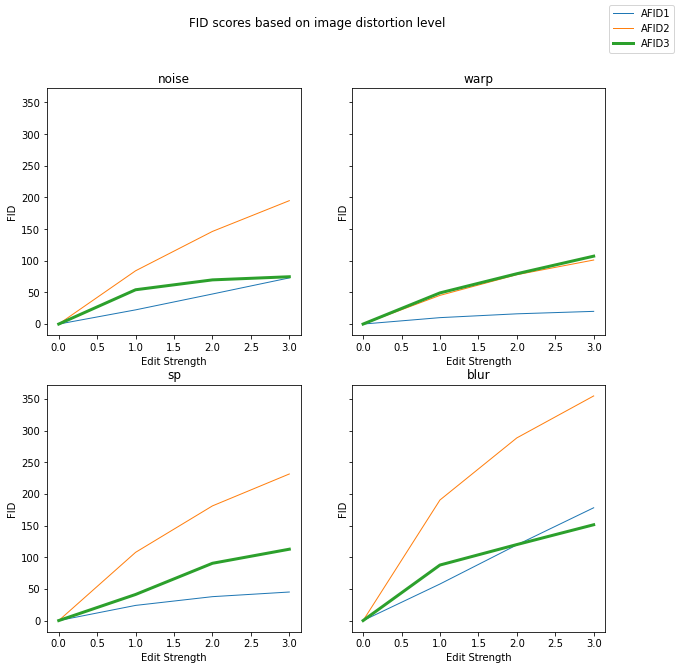

In [66]:
# Plot the results

dist_fids = [noise_fids, blur_fids, warp_fids, sp_fids]
fig, axs = afid_plot_2x2(dist_fids)

## Example 3 - Directory of images

In [ ]:
# def img_dir_to_tensor(path):
#   '''
#   Loads a directory of images into a single 4D-tensor.
#     Parameters: path - filepath to image directory
#     Returns: stack - 4D image tensor, torch.Tensor shape [NxHxWxC]
#   '''
#   tensor_list = []
#   images = glob.glob(path + '/*.jpg')
#   for img_file in images:
#     img = load_img_as_tensor(img_file, extra_dim=False)
#     tensor_list.append(img)
#   stack = torch.stack(tensor_list)
#   return stack

path1 = '/content/drive/MyDrive/GAN_Research/Datasets/CelebA_Smiles/real_A/'
path2 = '/content/drive/MyDrive/GAN_Research/Datasets/CelebA_Smiles/fake_B/'

import time
start = time.time()
imgs1 = load_images(path1)
end = time.time()
print('total load time: {} seconds'.format(str(end-start)))
imgs2 = load_images(path2)

total load time: 677.0982654094696 seconds


In [ ]:
fid_value1, fid_value2, fid_value3 = calculate_afid(imgs1,imgs2, use_multiprocessing=False, batch_size=1)
print(fid_value1)
print(fid_value2)
print(fid_value3)

2.2593089623611395
12.989164541184293
43.59659756312675


# CycleGAN AFID Results

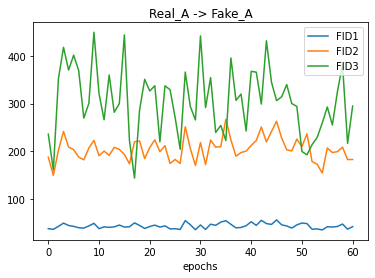

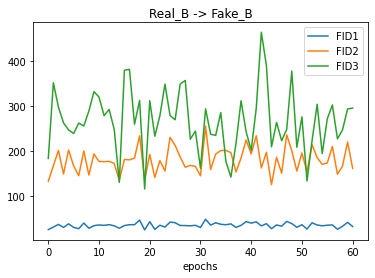

In [ ]:
import pandas as pd

df_A = pd.read_csv('/content/drive/MyDrive/GAN_Research/CycleGAN/models/smile/smile_fid_A.csv',
                 names=['epochs','FID1','FID2','FID3'])
df_B = pd.read_csv('/content/drive/MyDrive/GAN_Research/CycleGAN/models/smile/smile_fid_B.csv',
                 names=['epochs','FID1','FID2','FID3'])

sma = 5

# df_A['FID1_SMA_4'] = df_A.iloc[:,1].rolling(window=sma).mean()
# df_A['FID2_SMA_4'] = df_A.iloc[:,2].rolling(window=sma).mean()
# df_A['FID3_SMA_4'] = df_A.iloc[:,3].rolling(window=sma).mean()

# df_B['FID1_SMA_4'] = df_B.iloc[:,1].rolling(window=sma).mean()
# df_B['FID2_SMA_4'] = df_B.iloc[:,2].rolling(window=sma).mean()
# df_B['FID3_SMA_4'] = df_B.iloc[:,3].rolling(window=sma).mean()

legend=True

df_A.plot(x='epochs', legend=legend, title='Real_A -> Fake_A')
df_B.plot(x='epochs', legend=legend, title='Real_B -> Fake_B')

# Other